# 24/10/03 - Estudos de redes com de 3 e 4 camadas e de 8 a 32 neurônios e validação no treino



## Resumo

- Função de perda: RMSE
- Parânmetros do modelo: k--0.1__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0
- Funções de  ativação: 
    - Elu 
    - Tanh
    - ReLU
    - SiLU

- Tamanhos de batelada e épocas:
    - (800, 1090)

- Arquivo de checkpoint: 
    - 1727462177
    - 1727975986

- Peso da perda de cond. inicial: 10

- Peso da perda de dados: 10

## Análise de erro vs speedup

In [1]:
import glob
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tools import generate_model, train_data
import pandas as pd

In [2]:
result_list = glob.glob("pinn_sim/*")

print("numero de arquiteturas testadas: {}".format(len(result_list)))

numero de arquiteturas testadas: 2001


In [3]:
results_dict = {}

error_list = []

speed_list = []

n_layers_list = []

n_neurons_list = []

for file in result_list:
    i = len(error_list)
    if file.split(".")[-1] == "pkl":
        with open(file, "rb") as f:
            aux_dict = pk.load(f)

        results_dict[i] = {
            "rmse": aux_dict["rmse"],
            "max_ae": aux_dict["max_ae"],
            "mean_speed_up": aux_dict["mean_speed_up"],
            "std_speed_up": aux_dict["std_speed_up"],
            "arch_name": file.split("/")[-1].split(".")[0],
            "file": file,
        }

        results_dict[i]["arch_name"] = file.split("/")[-1].split(".")[0]

        layers_list = file.split("/")[-1].split(".")[0].split("__")[2:]

        layers_list.pop(-1)

        results_dict[i]["n_layers"] = len(layers_list)

        n_neurons = 0

        for layer in layers_list:

            n_neurons += int(layer.split("--")[-1])

        results_dict[i]["n_neurons"] = n_neurons

        error_list.append(results_dict[i]["rmse"] + results_dict[i]["max_ae"])
        speed_list.append(
            results_dict[i]["mean_speed_up"] - results_dict[i]["std_speed_up"]
        )
        n_layers_list.append(len(layers_list))
        n_neurons_list.append(n_neurons)

In [4]:
results_df = pd.DataFrame(
    np.array((error_list, speed_list, n_layers_list, n_neurons_list)).T,
    columns=["error", "speed", "n_layers", "n_neurons"],
)

results_df.head()

,error,speed,n_layers,n_neurons
0,0.507903,92.881156,3.0,32.0
1,0.234841,54.998201,3.0,96.0
2,0.450972,76.214056,3.0,32.0
3,0.508633,72.289541,4.0,48.0
4,0.509583,58.296276,4.0,48.0


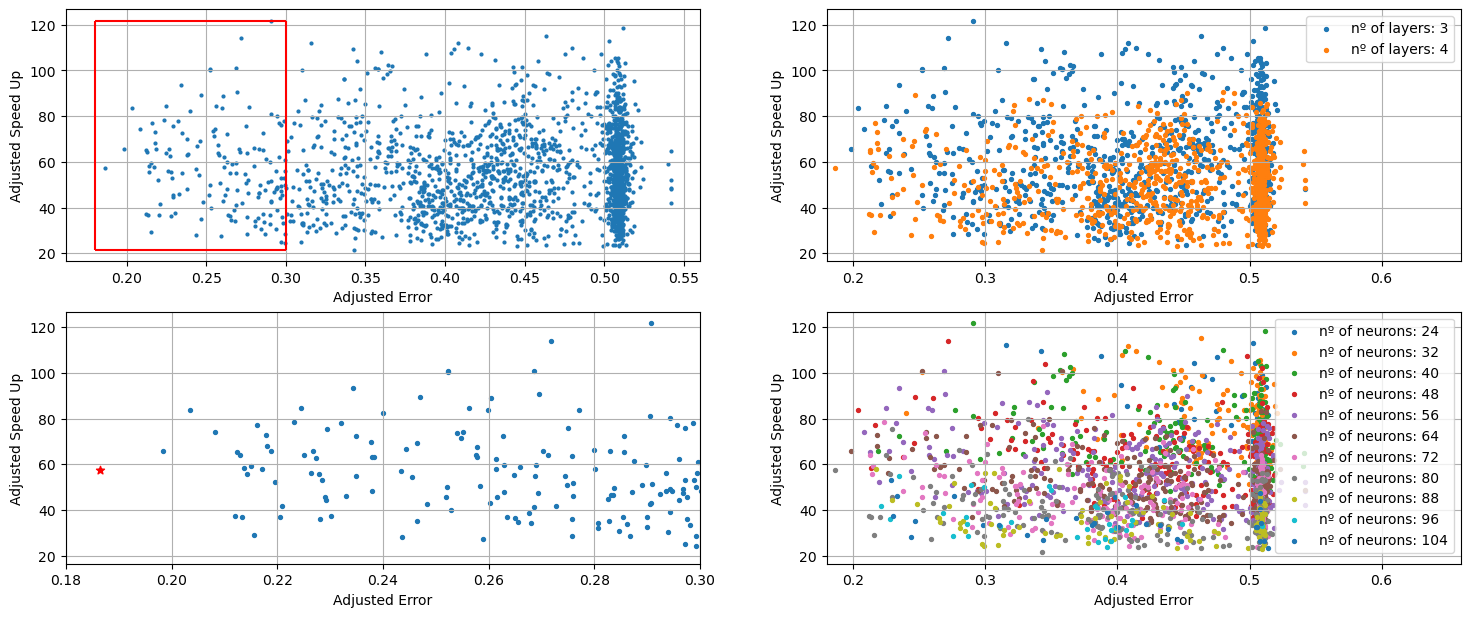

Arquitetura escolhida: epochs_1090__batch_800__arch_Elu--8__Elu--32__ReLU--8__ReLU--32__
Erro absoluto médio 0.014988112
Erro absoluto máximo 0.17152728
Speed Up: 73.30531584548021 +/-15.886545383113047


In [10]:
x_lim = (0.18, 0.3)

fig = plt.figure(figsize=[30 * 0.6, 12 * 0.6])

# fig.suptitle("Curva de aprendizagem", fontsize=16)

ax = fig.add_subplot(2, 2, 1)

ax.scatter(results_df.error, results_df.speed, s=4)
ax.hlines(max(results_df.speed), x_lim[0], x_lim[1], color="r")
ax.hlines(min(results_df.speed), x_lim[0], x_lim[1], color="r")
ax.vlines(x_lim[1], min(results_df.speed), max(results_df.speed), color="r")
ax.vlines(x_lim[0], min(results_df.speed), max(results_df.speed), color="r")

choice = np.intersect1d(
    np.argwhere(np.array(results_df.speed) < 60),
    np.argwhere(np.array(results_df.error) < 0.2),
)[0]

ax.set_xlabel("Adjusted Error")
ax.set_ylabel("Adjusted Speed Up")

ax.grid()

ax = fig.add_subplot(2, 2, 3)

ax.scatter(results_df.error, results_df.speed, s=8)
ax.scatter(results_df.error[choice], results_df.speed[choice], c="r", marker="*")
ax.set_xlim(x_lim[0], x_lim[1])

ax.set_xlabel("Adjusted Error")
ax.set_ylabel("Adjusted Speed Up")

ax.grid()


ax = fig.add_subplot(2, 2, 2)

unique_n_layers = np.unique(results_df.n_layers)

for n_layers in unique_n_layers:
    sub_df = results_df[results_df.n_layers == int(n_layers)]

    ax.scatter(
        sub_df.error, sub_df.speed, s=8, label="nº of layers: {}".format(int(n_layers))
    )

ax.set_xlabel("Adjusted Error")
ax.set_ylabel("Adjusted Speed Up")
ax.legend()
ax.set_xlim(x_lim[0], 0.66)
ax.grid()

ax = fig.add_subplot(2, 2, 4)

unique_n_neurons = np.unique(results_df.n_neurons)

for n_neurons in unique_n_neurons:
    sub_df = results_df[results_df.n_neurons == int(n_neurons)]

    ax.scatter(
        sub_df.error,
        sub_df.speed,
        s=8,
        label="nº of neurons: {}".format(int(n_neurons)),
    )

ax.set_xlabel("Adjusted Error")
ax.set_ylabel("Adjusted Speed Up")
ax.legend()
ax.set_xlim(x_lim[0], 0.66)
ax.grid()

plt.show()

arch_str = results_dict[choice]["arch_name"]

print("Arquitetura escolhida: " + arch_str)
print("Erro absoluto médio", results_dict[choice]["rmse"])
print("Erro absoluto máximo", results_dict[choice]["max_ae"])
print(
    "Speed Up: {} +/-{}".format(
        results_dict[choice]["mean_speed_up"], results_dict[choice]["std_speed_up"]
    )
)

In [11]:
with open("learning_curves/C_pde_loss_it__" + arch_str + ".pkl", "rb") as f:
    C_pde_loss_it = pk.load(f)

with open("learning_curves/C_data_loss_it__" + arch_str + ".pkl", "rb") as f:
    C_data_loss_it = pk.load(f)

with open("learning_curves/C_boundary_loss_it__" + arch_str + ".pkl", "rb") as f:
    C_boundary_loss_it = pk.load(f)

with open("learning_curves/C_initial_loss_it__" + arch_str + ".pkl", "rb") as f:
    C_initial_loss_it = pk.load(f)

with open("learning_curves/val_loss_it__" + arch_str + ".pkl", "rb") as f:
    val_loss_it = pk.load(f)

results_dict[choice]

with open(results_dict[choice]["file"], "rb") as f:
    aux_dict = pk.load(f)
    Cl_pinn_lin = aux_dict["Cl_pinn"].numpy()
    Cp_pinn_lin = aux_dict["Cp_pinn"].numpy()

size_t = int(len(Cl_pinn_lin) ** 0.5)

struct_name = "h--0.1__k--0.1__Db--0.0001__Dn--0.0001__phi--0.2__ksi--0.0__cb--0.15__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__Cn_max--0.5__X_nb--0.0001__x_dom_min--0__x_dom_max--1__y_dom_min--0__y_dom_max--1__t_dom_min--0__t_dom_max--10"


with open("fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
    Cp = pk.load(f)

with open("fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
    Cl = pk.load(f)


x_dom = (0, 1)
y_dom = (0, 1)
t_dom = (0, 10)
h = 0.1
k = 0.1

size_x = int(((x_dom[1] - x_dom[0]) / (h))) + 1
size_y = int(((y_dom[1] - y_dom[0]) / (h))) + 1
size_t = int(((t_dom[1] - t_dom[0]) / (k))) + 1

Cp_pinn_np = Cp_pinn_lin.reshape(size_t, size_x, size_y)
Cl_pinn_np = Cl_pinn_lin.reshape(size_t, size_x, size_y)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y_np = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)


X, Y = np.meshgrid(
    x_np,
    y_np,
)

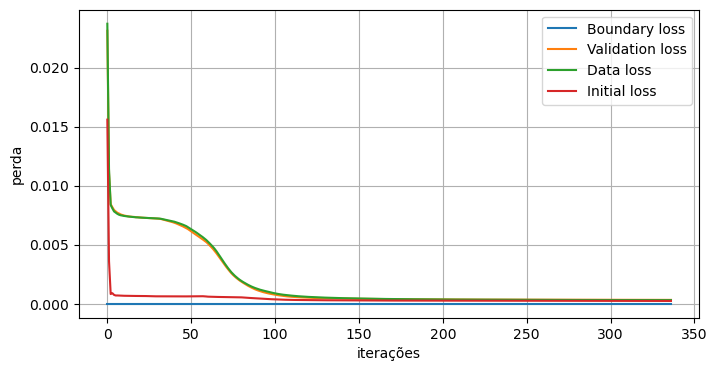

In [12]:
scale_factor = 0.5
fig = plt.figure(figsize=[16 * scale_factor, 8 * scale_factor])

# fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_boundary_loss_it)),
    C_boundary_loss_it,
    label="Boundary loss",
)

ax.plot(
    range(len(val_loss_it)),
    val_loss_it,
    label="Validation loss",
)

ax.plot(
    range(len(C_data_loss_it)),
    C_data_loss_it,
    label="Data loss",
)

ax.plot(
    range(len(C_initial_loss_it)),
    C_initial_loss_it,
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()
# ax.set_xlim(-1,400)

plt.show()

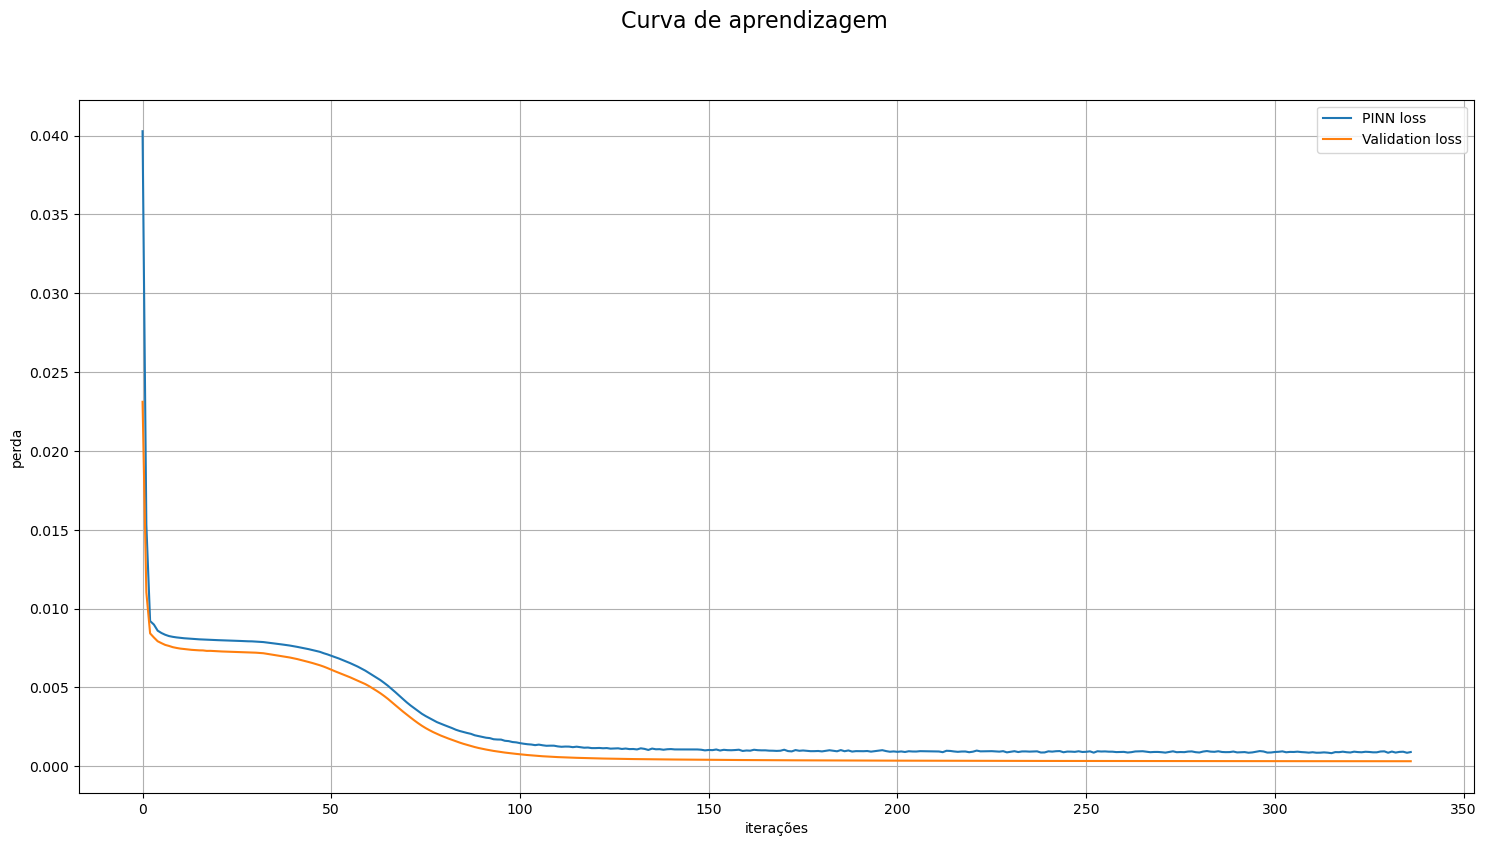

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

ax.plot(
    range(len(C_initial_loss_it)),
    C_initial_loss_it + C_pde_loss_it + C_data_loss_it,
    label="PINN loss",
)
ax.plot(
    range(len(val_loss_it)),
    val_loss_it,
    label="Validation loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()
# ax.set_xlim(-1, 400)

plt.show()

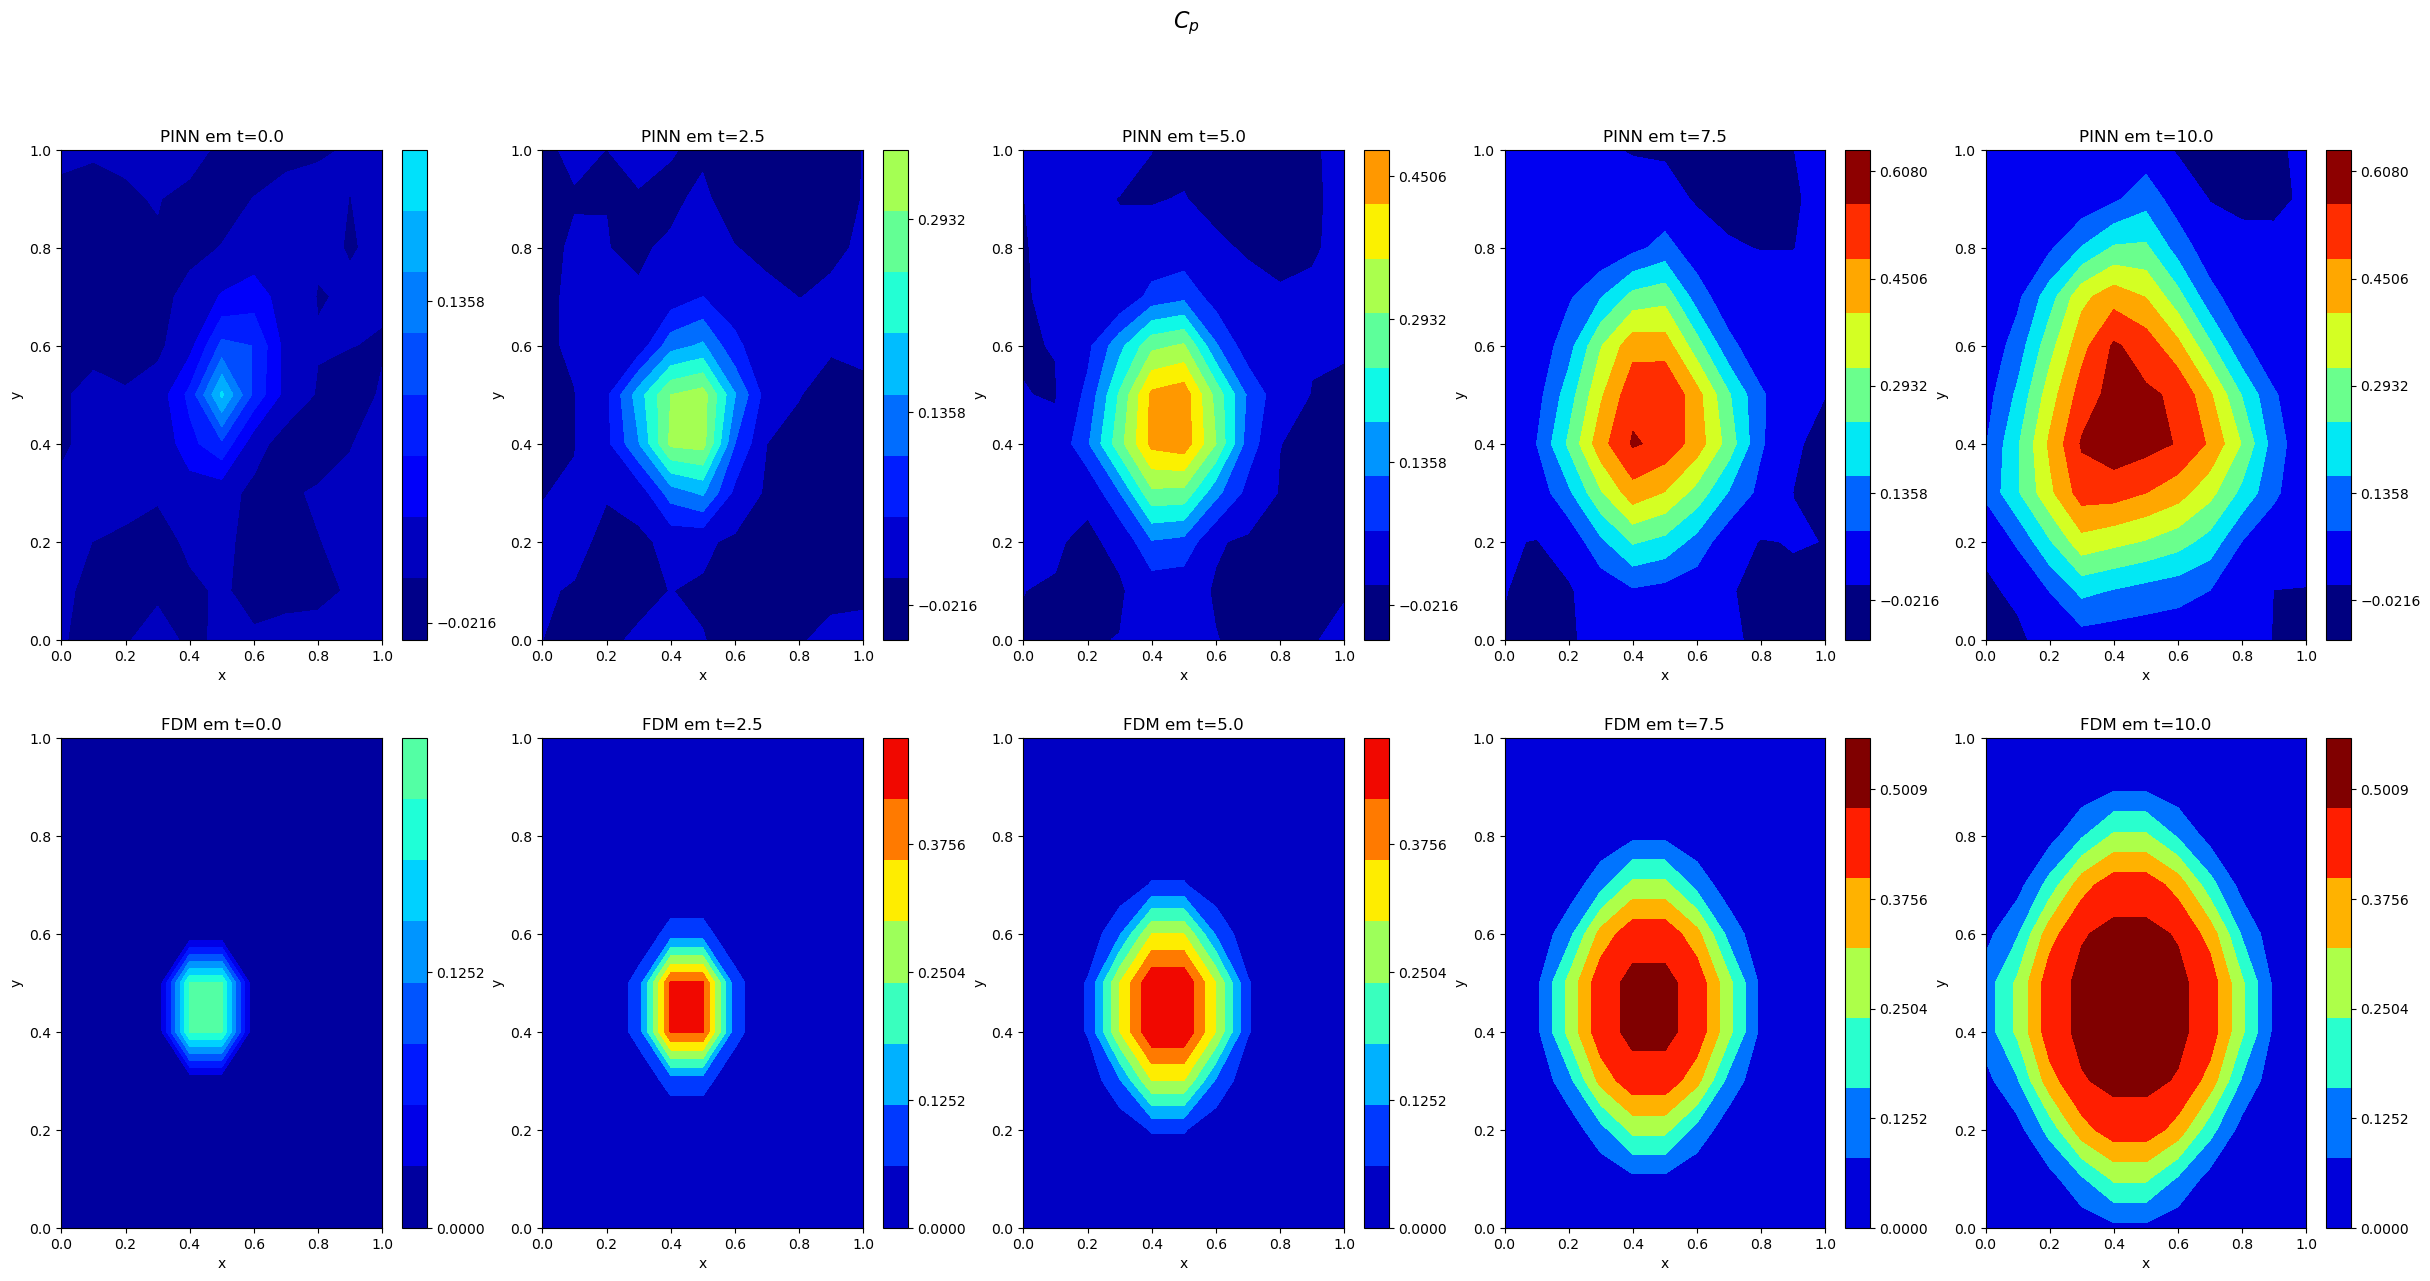

In [14]:
time_plot = np.linspace(0, len(t_np) - 1, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("$C_p$", fontsize=16)

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + 1)

    vmin = np.min(Cp_pinn_np)
    vmax = np.max(Cp_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("PINN em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cp)
    vmax = np.max(Cp)

    contour = ax.contourf(
        X,
        Y,
        Cp[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("FDM em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

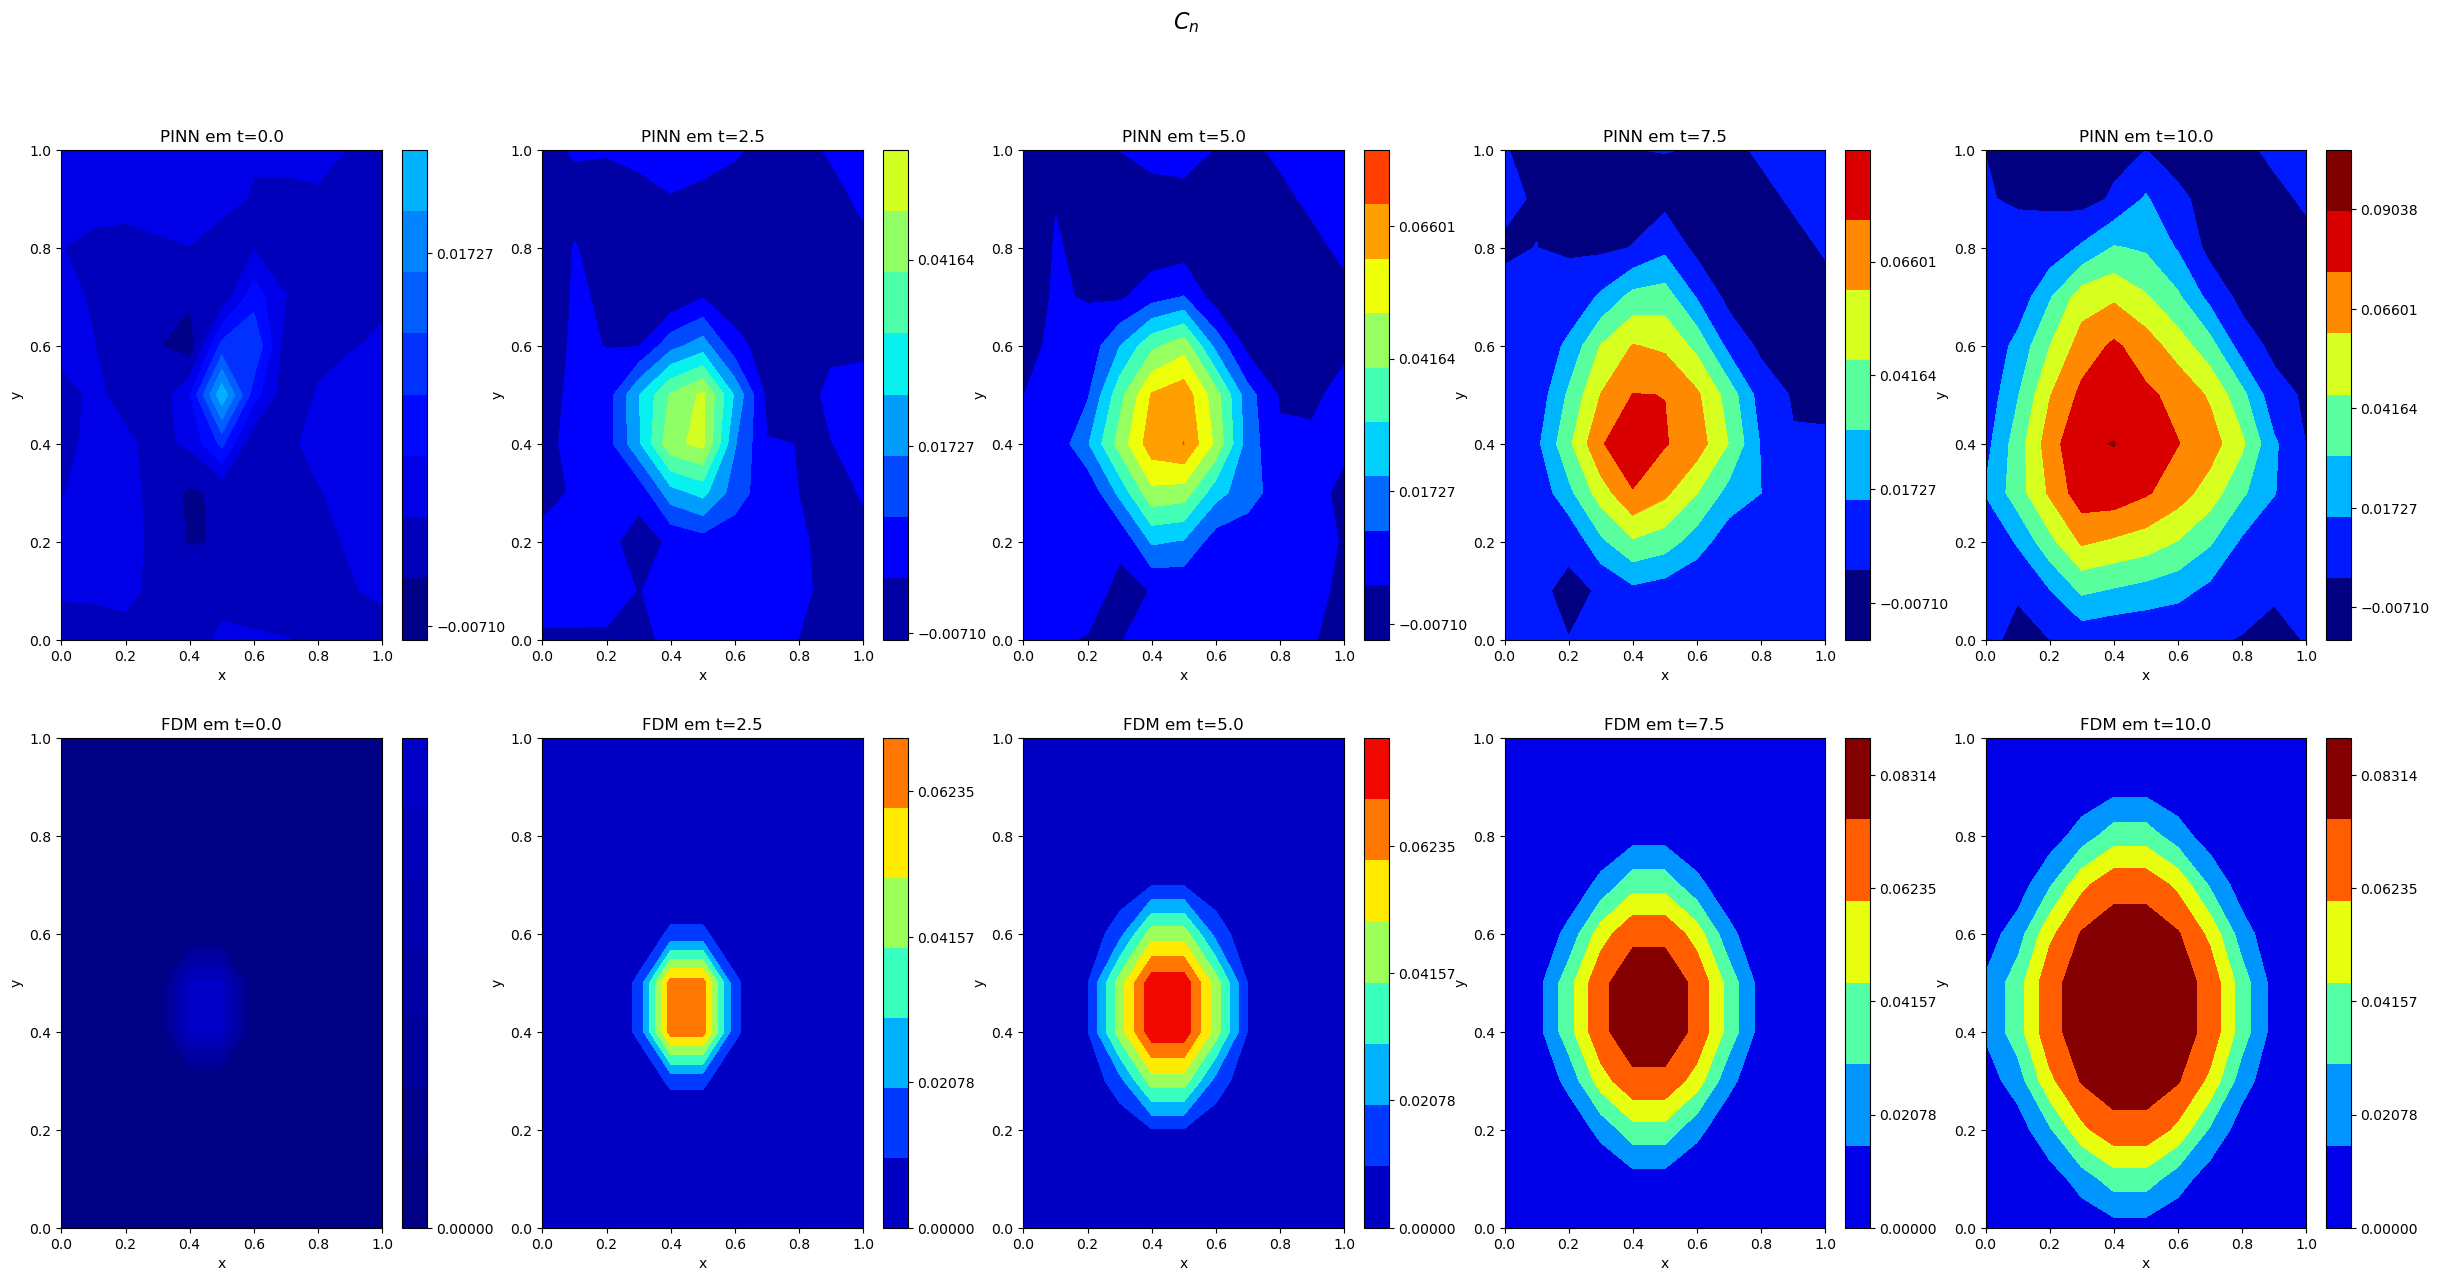

In [15]:
time_plot = np.linspace(0, len(t_np) - 1, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("$C_n$", fontsize=16)

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + 1)

    vmin = np.min(Cl_pinn_np)
    vmax = np.max(Cl_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("PINN em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cl)
    vmax = np.max(Cl)

    contour = ax.contourf(
        X,
        Y,
        Cl[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("FDM em t={}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

# 25/02/18 - Estudos de redes com de 4 camadas e de 8 a 32 neurônios e validação no treino



## Resumo

- Função de perda: RMSE
- Funções de  ativação: 
    - Elu 
    - Sigmoid
    - Tanh
    - ReLU
    - SiLU

- Tamanhos de batelada e épocas:
    - (108000, 300)

- Arquivo de checkpoint: 
    - 1727462177

- Peso da perda de cond. inicial: 10

- Peso da perda de pde: 0.1

- Peso da perda de fronteira: 0.5

- Peso da perda de dados: 10

## Análise de erro vs speedup

In [1]:
import glob
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tools import generate_model, train_data
import pandas as pd

In [2]:
result_list = glob.glob("pinn_sim/*")

result_type = list(map(lambda file: file.split("/")[-1].split("_")[0], result_list))

print("numero de arquiteturas testadas: {}".format(len(result_list)))

numero de arquiteturas testadas: 2013


In [21]:
results_dict = {}

error_list = []

speed_list = []

n_layers_list = []

n_neurons_list = []

key_error = 0

output_type = 0

prediction_type = 0

for file, ft in zip(result_list, result_type):
    i = len(error_list)

    if file.split(".")[-1] == "pkl" and ft == "output":
        with open(file, "rb") as f:
            aux_dict = pk.load(f)

        try:
            results_dict[i] = {
                "rmse": aux_dict["rmse"],
                "max_ae": aux_dict["max_ae"],
                "mean_speed_up": aux_dict["mean_speed_up"],
                "std_speed_up": aux_dict["std_speed_up"],
                "arch_name": file.split("/")[-1].split(".")[0],
                "file": file,
            }

            results_dict[i]["arch_name"] = ("_").join(
                file.split("/")[-1].split(".")[0].split("_")[1:]
            )

            layers_list = file.split("/")[-1].split(".")[0].split("__")[2:]

            layers_list.pop(-1)

            results_dict[i]["n_layers"] = len(layers_list)

            n_neurons = 0

            for layer in layers_list:

                n_neurons += int(layer.split("--")[-1])

            results_dict[i]["n_neurons"] = n_neurons

            error_list.append(results_dict[i]["rmse"])
            speed_list.append(
                results_dict[i]["mean_speed_up"]
            )
            n_layers_list.append(len(layers_list))
            n_neurons_list.append(n_neurons)

            output_type += 1

        except:
            key_error += 1

    else:
        prediction_type += 1

print(f"There are {key_error} Dictionary wrongly created")
print(f"There are {output_type} output_type")
print(f"There are {key_error} prediction_type")

There are 0 Dictionary wrongly created
There are 1006 output_type
There are 0 prediction_type


In [22]:
results_df = pd.DataFrame(
    np.array((error_list, speed_list, n_layers_list, n_neurons_list)).T,
    columns=["error", "speed", "n_layers", "n_neurons"],
)

results_df.head()

,error,speed,n_layers,n_neurons
0,0.018084,612.520095,4.0,48.0
1,0.016712,612.520095,4.0,72.0
2,0.012936,612.520095,4.0,40.0
3,0.005630,612.520095,4.0,96.0
4,0.016806,612.520095,4.0,48.0


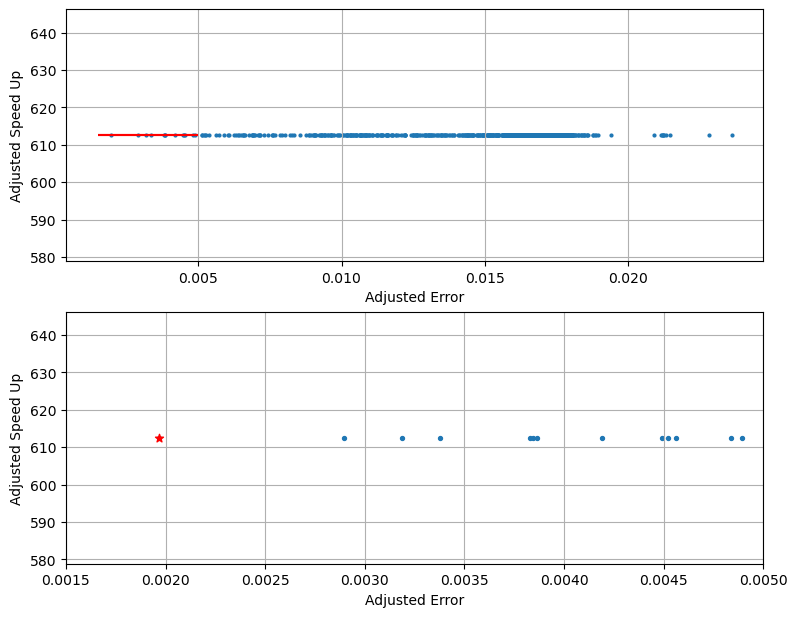

In [24]:
x_lim = (0.0015, 0.005)

fig = plt.figure(figsize=[15 * 0.6, 12 * 0.6])

# fig.suptitle("Curva de aprendizagem", fontsize=16)

ax = fig.add_subplot(2, 1, 1)

ax.scatter(results_df.error, results_df.speed, s=4)
ax.hlines(max(results_df.speed), x_lim[0], x_lim[1], color="r")
ax.hlines(min(results_df.speed), x_lim[0], x_lim[1], color="r")
ax.vlines(x_lim[1], min(results_df.speed), max(results_df.speed), color="r")
ax.vlines(x_lim[0], min(results_df.speed), max(results_df.speed), color="r")

choice = np.intersect1d(
    np.argwhere(np.array(results_df.speed) > 590),
    np.argwhere(np.array(results_df.error) < 0.002),
)[0]

ax.set_xlabel("Adjusted Error")
ax.set_ylabel("Adjusted Speed Up")

ax.grid()

ax = fig.add_subplot(2, 1, 2)

ax.scatter(results_df.error, results_df.speed, s=8)
ax.scatter(results_df.error[choice], results_df.speed[choice], c="r", marker="*")
ax.set_xlim(x_lim[0], x_lim[1])

ax.set_xlabel("Adjusted Error")
ax.set_ylabel("Adjusted Speed Up")

ax.grid()


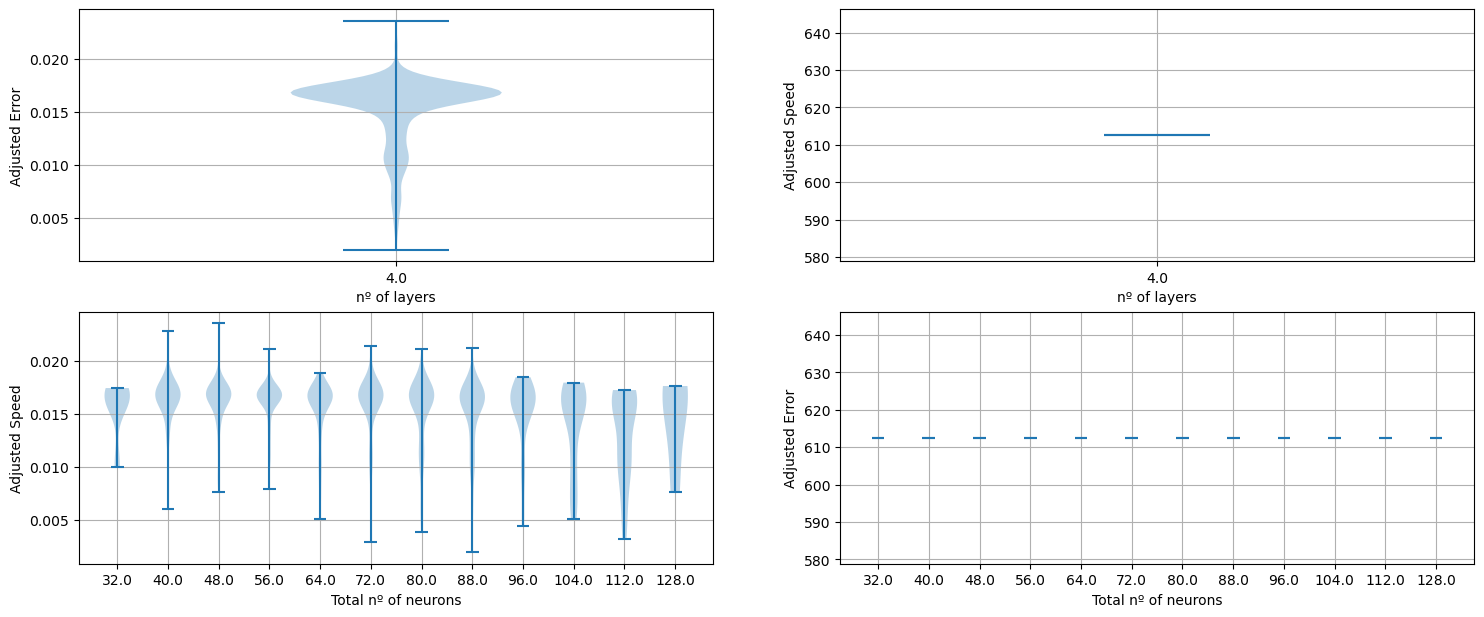

In [25]:
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel("Sample name")


fig = plt.figure(figsize=[30 * 0.6, 12 * 0.6])

ax = fig.add_subplot(2, 2, 1)

unique_n_layers = np.unique(results_df.n_layers)

collection = []

for n_layers in unique_n_layers:
    sub_df = results_df[results_df.n_layers == int(n_layers)]

    collection.append(sub_df.error)


ax.violinplot(collection)

set_axis_style(ax, unique_n_layers)
ax.set_xlabel("nº of layers")
ax.set_ylabel("Adjusted Error")
# ax.set_xlim(y_[0], 0.42)
ax.grid()

ax = fig.add_subplot(2, 2, 2)

collection = []

for n_layers in unique_n_layers:
    sub_df = results_df[results_df.n_layers == int(n_layers)]

    collection.append(sub_df.speed)


ax.violinplot(collection)

set_axis_style(ax, unique_n_layers)
ax.set_xlabel("nº of layers")
ax.set_ylabel("Adjusted Speed")
# ax.set_xlim(x_lim[1], 0.42)
ax.grid()


ax = fig.add_subplot(2, 2, 3)

unique_n_neurons = np.unique(results_df.n_neurons)

collection = []

for n_neurons in unique_n_neurons:
    sub_df = results_df[results_df.n_neurons == int(n_neurons)]

    collection.append(sub_df.error)

ax.violinplot(collection)

set_axis_style(ax, unique_n_neurons)
ax.set_xlabel("Total nº of neurons")
ax.set_ylabel("Adjusted Speed")
# ax.set_xlim(x_lim[0], 0.43)
ax.grid()


ax = fig.add_subplot(2, 2, 4)

collection = []

for n_neurons in unique_n_neurons:
    sub_df = results_df[results_df.n_neurons == int(n_neurons)]

    collection.append(sub_df.speed)

ax.violinplot(collection)

set_axis_style(ax, unique_n_neurons)
ax.set_xlabel("Total nº of neurons")
ax.set_ylabel("Adjusted Error")
# ax.set_xlim(x_lim[0], 0.43)
ax.grid()

plt.show()

In [31]:
arch_str = results_dict[choice]["arch_name"]

with open("learning_curves/C_pde_loss_it_" + arch_str + ".pkl", "rb") as f:
    C_pde_loss_it = pk.load(f)

with open("learning_curves/C_data_loss_it_" + arch_str + ".pkl", "rb") as f:
    C_data_loss_it = pk.load(f)

with open("learning_curves/C_boundary_loss_it_" + arch_str + ".pkl", "rb") as f:
    C_boundary_loss_it = pk.load(f)

with open("learning_curves/C_initial_loss_it_" + arch_str + ".pkl", "rb") as f:
    C_initial_loss_it = pk.load(f)

with open("learning_curves/val_loss_it_" + arch_str + ".pkl", "rb") as f:
    val_loss_it = pk.load(f)



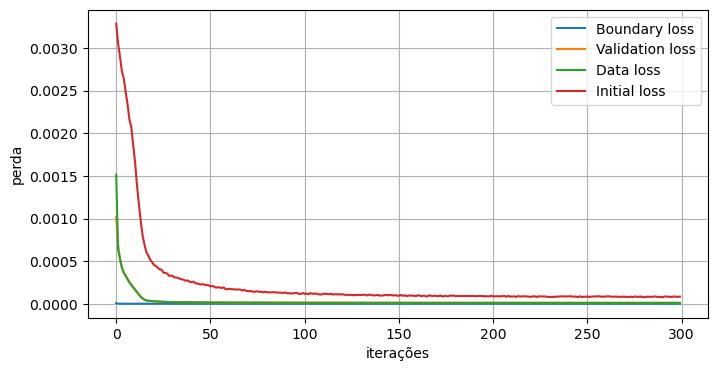

In [32]:
scale_factor = 0.5
fig = plt.figure(figsize=[16 * scale_factor, 8 * scale_factor])

# fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_boundary_loss_it)),
    C_boundary_loss_it,
    label="Boundary loss",
)

ax.plot(
    range(len(val_loss_it)),
    val_loss_it,
    label="Validation loss",
)

ax.plot(
    range(len(C_data_loss_it)),
    C_data_loss_it,
    label="Data loss",
)

ax.plot(
    range(len(C_initial_loss_it)),
    C_initial_loss_it,
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()
# ax.set_xlim(-1,400)

plt.show()

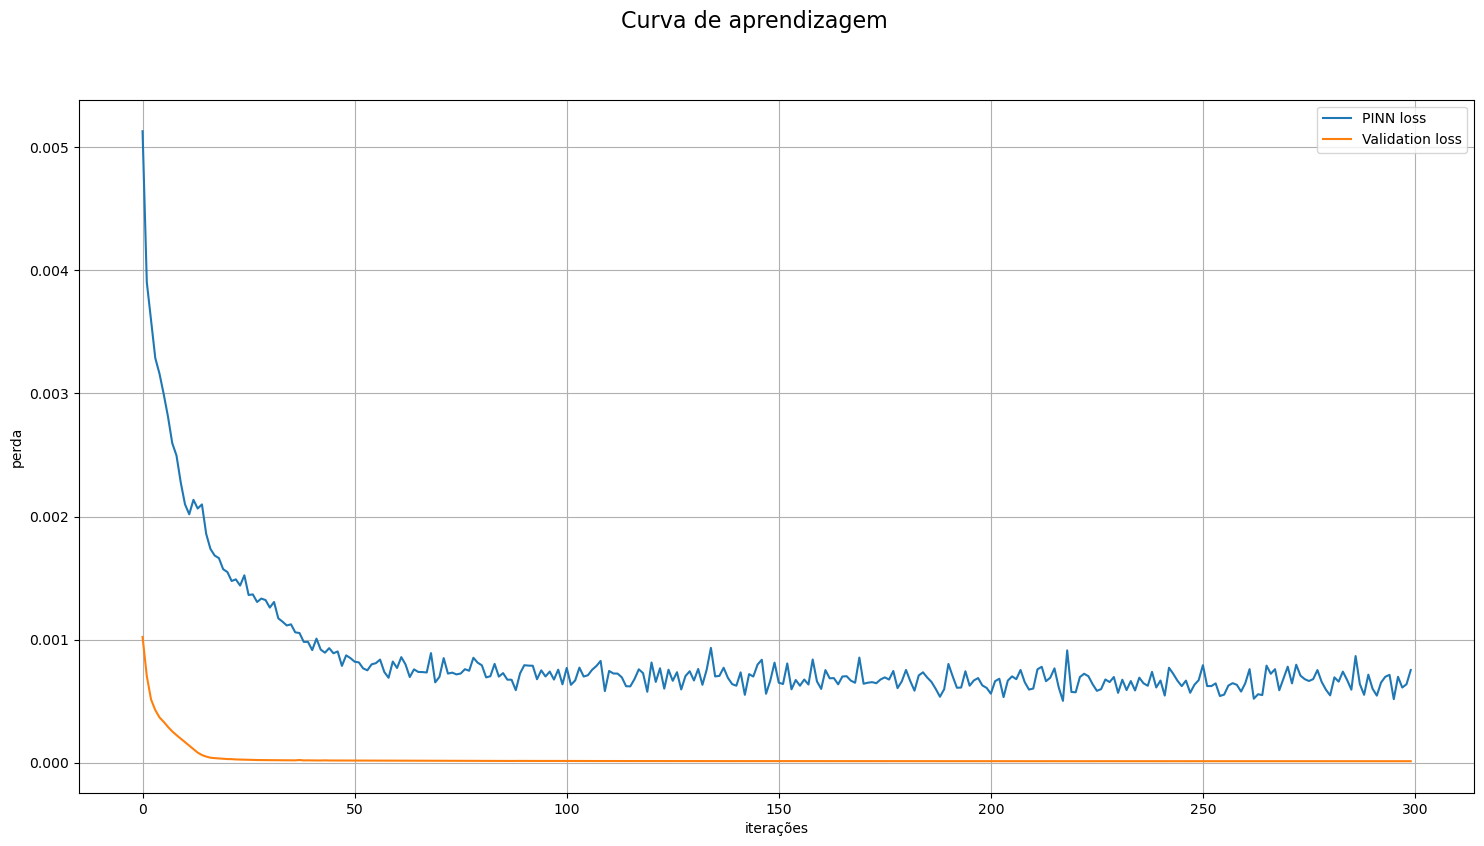

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

ax.plot(
    range(len(C_initial_loss_it)),
    C_initial_loss_it + C_pde_loss_it + C_data_loss_it,
    label="PINN loss",
)
ax.plot(
    range(len(val_loss_it)),
    val_loss_it,
    label="Validation loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()
# ax.set_xlim(-1, 400)

plt.show()

In [48]:
arch_str

'epochs_300__batch_108000__arch_Tanh--8__ReLU--32__ReLU--32__ReLU--16__'

In [38]:
with open("pinn_sim/prediction_" + arch_str + ".pkl", "rb") as f:
    predictions = pk.load(f)

In [46]:
import json 
from pinn import *

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

central_ini_cond = constant_properties["central_ini_cond"]
ini_cond_var = constant_properties["ini_cond_var"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]

size_x, size_y, size_t, initial_cond = get_mesh_properties(
    x_dom, y_dom, t_dom, h, k, central_ini_cond, ini_cond_var, 1
)

Cl_pinn = predictions["pred_pinn"][:,0]
Cp_pinn = predictions["pred_pinn"][:,1]

Cl_pinn = Cl_pinn.reshape((size_t,size_x,size_y))
Cp_pinn = Cp_pinn.reshape((size_t,size_x,size_y))

Cl_fvm = predictions["target"][:,0]
Cp_fvm = predictions["target"][:,1]

Cl_fvm = Cl_fvm.reshape((size_t,size_x,size_y))
Cp_fvm = Cp_fvm.reshape((size_t,size_x,size_y))

Steps in time = 10001
Steps in space_x = 20
Steps in space_y = 20



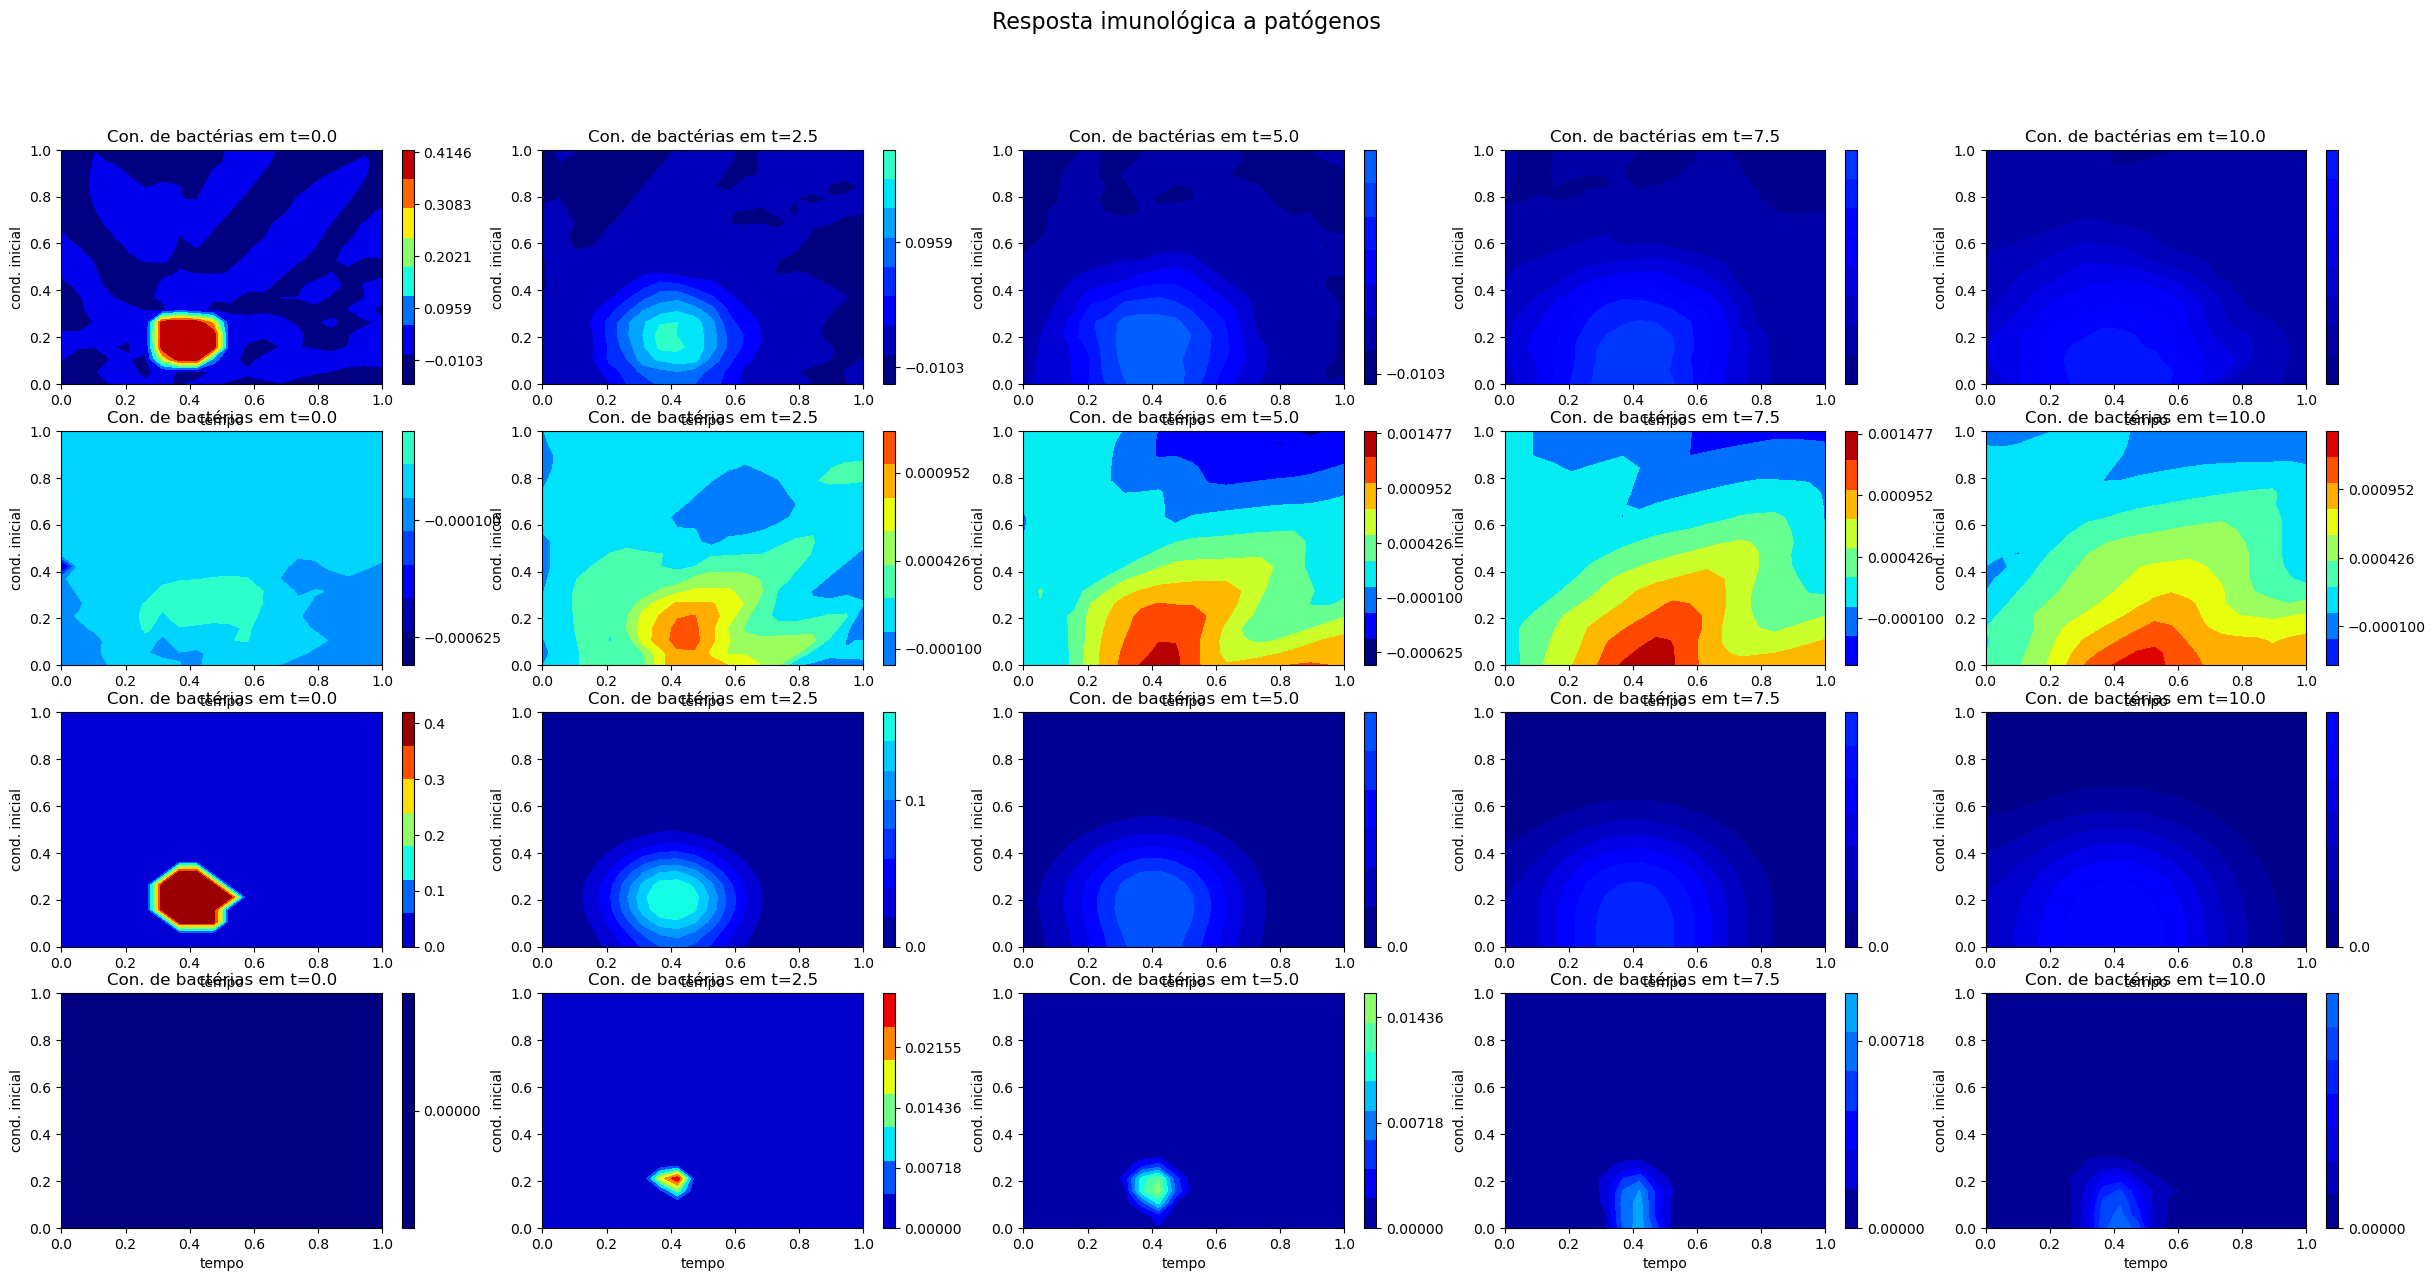

In [47]:
t = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)

X, Y = np.meshgrid(x, y)

time_plot = np.linspace(0, len(t) - 1, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + 1)

    vmin = np.min(Cp_pinn)
    vmax = np.max(Cp_pinn)

    contour = ax.contourf(
        X,
        Y,
        Cp_pinn[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cl_pinn)
    vmax = np.max(Cl_pinn)

    contour = ax.contourf(
        X,
        Y,
        Cl_pinn[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 2 + 1)

    vmin = np.min(Cp_fvm)
    vmax = np.max(Cp_fvm)

    contour = ax.contourf(
        X,
        Y,
        Cp_fvm[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 3 + 1)

    vmin = np.min(Cl_fvm)
    vmax = np.max(Cl_fvm)

    contour = ax.contourf(
        X,
        Y,
        Cl_fvm[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()